# Air Quality Analysis - Module Demo

This notebook demonstrates the `air_quality` modules developed for PM2.5 analysis.

## Modules Available:
- `air_quality.statistics` - Statistical analysis functions
- `air_quality.extremes` - Extreme value identification
- `air_quality.trends` - Temporal trend analysis

We'll demonstrate each function with the air quality dataset.


## Setup

Import modules and load data:


In [505]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Import our modules
from air_quality.statistics import (
    calculate_daily_mean,
    calculate_rolling_average,
    calculate_exceedance_count,
    calculate_aqi
)
from air_quality.extremes import (
    identify_extremes_threshold,
    identify_extremes_percentile,
    identify_consecutive_exceedances
)
from air_quality.data_loader import (
    load_pm25_data,
    filter_by_city,
    get_cities_list
)
from scripts.plot_helpers import (
    get_plot_style,
    get_city_colors,
    get_common_kwargs,
    setup_subplot_grid
)

# Load data
df = pd.read_csv('data/all_cities_pm25.csv', parse_dates=['date'])
print(f"Loaded {len(df)} observations")
print(f"\nCities: {df['city'].unique().tolist()}")
print(f"\nData preview:")
print(df.head())


Loaded 2196 observations

Cities: ['Los Angeles', 'Fresno', 'Phoenix', 'Denver', 'Salt Lake City', 'Pittsburgh']

Data preview:
        date         city pollutant      value
0 2024-01-01  Los Angeles     PM2.5  22.445674
1 2024-01-02  Los Angeles     PM2.5  13.680909
2 2024-01-03  Los Angeles     PM2.5   8.141040
3 2024-01-04  Los Angeles     PM2.5   6.034635
4 2024-01-05  Los Angeles     PM2.5  11.618910


## 1. Statistics Module Demo

### Function: `calculate_daily_mean()`
Calculates the mean of PM2.5 values using NumPy.


In [506]:
# Calculate mean PM2.5 for each city
print("Average PM2.5 by City:")
print("-" * 40)
for city in df['city'].unique():
    city_data = df[df['city'] == city]['value'].values
    mean_val = calculate_daily_mean(city_data)
    print(f"{city}: {mean_val:.2f} μg/m³")


Average PM2.5 by City:
----------------------------------------
Los Angeles: 10.87 μg/m³
Fresno: 10.03 μg/m³
Phoenix: 8.55 μg/m³
Denver: 6.64 μg/m³
Salt Lake City: 7.16 μg/m³
Pittsburgh: 7.73 μg/m³


### Function: `calculate_rolling_average()`
Computes a moving average with a specified window size.


In [507]:
# Calculate 7-day rolling average for all cities
print("7-Day Rolling Average (first non-NaN value for each city):")
print("-" * 60)

for city in df['city'].unique():
    city_data = df[df['city'] == city].sort_values('date')
    rolling_avg = calculate_rolling_average(city_data['value'].values, window=7)
    
    # Find first non-NaN value (day 7)
    first_valid_idx = 6  # 7th day (0-indexed)
    if first_valid_idx < len(rolling_avg):
        date_val = city_data['date'].iloc[first_valid_idx]
        orig_val = city_data['value'].iloc[first_valid_idx]
        roll_val = rolling_avg[first_valid_idx]
        print(f"{city:20s}: Day 7 ({date_val.strftime('%Y-%m-%d')}) "
              f"Original={orig_val:5.1f}, Rolling={roll_val:6.2f}")


7-Day Rolling Average (first non-NaN value for each city):
------------------------------------------------------------
Los Angeles         : Day 7 (2024-01-07) Original=  2.9, Rolling= 11.09
Fresno              : Day 7 (2024-01-07) Original=  7.1, Rolling= 11.86
Phoenix             : Day 7 (2024-01-07) Original=  5.5, Rolling= 21.02
Denver              : Day 7 (2024-01-07) Original=  5.3, Rolling=  9.04
Salt Lake City      : Day 7 (2024-01-07) Original=  1.1, Rolling= 12.39
Pittsburgh          : Day 7 (2024-01-07) Original=  8.5, Rolling=  7.11


### Function: `calculate_exceedance_count()`
Counts days exceeding a threshold (e.g., EPA daily standard of 35 μg/m³).


In [508]:
EPA_STANDARD = 35.0

print(f"Days Exceeding EPA Standard ({EPA_STANDARD} μg/m³):")
print("-" * 40)
for city in df['city'].unique():
    city_data = df[df['city'] == city]['value'].values
    count = calculate_exceedance_count(city_data, EPA_STANDARD)
    total = len(city_data)
    pct = (count/total*100) if total > 0 else 0
    print(f"{city}: {count} days ({pct:.1f}%)")


Days Exceeding EPA Standard (35.0 μg/m³):
----------------------------------------
Los Angeles: 3 days (0.8%)
Fresno: 6 days (1.6%)
Phoenix: 2 days (0.5%)
Denver: 0 days (0.0%)
Salt Lake City: 1 days (0.3%)
Pittsburgh: 0 days (0.0%)


### Function: `calculate_aqi()`
Converts PM2.5 concentration to EPA Air Quality Index with health categories.


In [509]:
# Demonstrate AQI calculation using actual city data
print("AQI Calculation for Selected Days from Dataset:")
print("-" * 70)
print(f"{'City':>15s} {'Date':>12s} {'PM2.5':>8s} {'AQI':>6s} {'Category':>35s}")
print("-" * 70)

# Get one example day from each city (the day with max PM2.5)
for city in df['city'].unique():
    city_data = df[df['city'] == city]
    max_idx = city_data['value'].idxmax()
    max_row = city_data.loc[max_idx]
    result = calculate_aqi(max_row['value'])
    print(f"{city:>15s} {max_row['date'].strftime('%Y-%m-%d'):>12s} "
          f"{max_row['value']:>8.1f} {result['aqi']:>6d} {result['category']:>35s}")


AQI Calculation for Selected Days from Dataset:
----------------------------------------------------------------------
           City         Date    PM2.5    AQI                            Category
----------------------------------------------------------------------
    Los Angeles   2024-07-05     40.3    113      Unhealthy for Sensitive Groups
         Fresno   2024-12-06     46.0    127      Unhealthy for Sensitive Groups
        Phoenix   2024-01-01     79.0    163                           Unhealthy
         Denver   2024-07-23     26.4     81                            Moderate
 Salt Lake City   2024-09-11     36.2    103      Unhealthy for Sensitive Groups
     Pittsburgh   2024-08-15     22.0     72                            Moderate


## 2. Extremes Module Demo

### Function: `identify_extremes_threshold()`
Identifies days where PM2.5 exceeds a specific threshold.


In [510]:
# Find extreme days for all cities using threshold method
print(f"Days Exceeding {EPA_STANDARD} μg/m³ by City:")
print("-" * 60)

for city in df['city'].unique():
    city_data = df[df['city'] == city].copy()
    # Rename columns for extremes module which expects 'Date' and 'PM2.5'
    city_data.rename(columns={'date': 'Date', 'value': 'PM2.5'}, inplace=True)
    extremes = identify_extremes_threshold(city_data, EPA_STANDARD)
    print(f"\n{city}: {len(extremes)} extreme days")
    if len(extremes) > 0:
        worst_day = extremes.iloc[0]
        print(f"  Worst day: {worst_day['Date'].strftime('%Y-%m-%d')} "
              f"(PM2.5 = {worst_day['PM2.5']:.1f} μg/m³)")


Days Exceeding 35.0 μg/m³ by City:
------------------------------------------------------------

Los Angeles: 3 extreme days
  Worst day: 2024-07-05 (PM2.5 = 40.3 μg/m³)

Fresno: 6 extreme days
  Worst day: 2024-12-06 (PM2.5 = 46.0 μg/m³)

Phoenix: 2 extreme days
  Worst day: 2024-01-01 (PM2.5 = 79.0 μg/m³)

Denver: 0 extreme days

Salt Lake City: 1 extreme days
  Worst day: 2024-09-11 (PM2.5 = 36.2 μg/m³)

Pittsburgh: 0 extreme days


### Function: `identify_extremes_percentile()`
Identifies extreme days based on percentile threshold (e.g., 95th percentile).


In [511]:
# Find 95th percentile extreme days for all cities
print(f"95th Percentile Extreme Days by City:")
print("-" * 60)

for city in df['city'].unique():
    city_data = df[df['city'] == city].copy()
    # Rename columns for extremes module
    city_data.rename(columns={'date': 'Date', 'value': 'PM2.5'}, inplace=True)
    percentile_extremes = identify_extremes_percentile(city_data, 95)
    print(f"\n{city}: {len(percentile_extremes)} extreme days")
    if len(percentile_extremes) > 0:
        worst_day = percentile_extremes.iloc[0]
        print(f"  Worst day: {worst_day['Date'].strftime('%Y-%m-%d')} "
              f"(PM2.5 = {worst_day['PM2.5']:.1f} μg/m³)")


95th Percentile Extreme Days by City:
------------------------------------------------------------

Los Angeles: 19 extreme days
  Worst day: 2024-07-05 (PM2.5 = 40.3 μg/m³)

Fresno: 19 extreme days
  Worst day: 2024-12-06 (PM2.5 = 46.0 μg/m³)

Phoenix: 19 extreme days
  Worst day: 2024-01-01 (PM2.5 = 79.0 μg/m³)

Denver: 19 extreme days
  Worst day: 2024-07-23 (PM2.5 = 26.4 μg/m³)

Salt Lake City: 19 extreme days
  Worst day: 2024-09-11 (PM2.5 = 36.2 μg/m³)

Pittsburgh: 19 extreme days
  Worst day: 2024-08-15 (PM2.5 = 22.0 μg/m³)


### Function: `identify_consecutive_exceedances()`
Finds consecutive sequences of days exceeding a threshold.


In [512]:
# Find consecutive exceedance periods for all cities
print(f"Consecutive Exceedance Periods (>{EPA_STANDARD} μg/m³):")
print("=" * 60)

for city in df['city'].unique():
    city_data = df[df['city'] == city].copy()
    # Rename columns for extremes module
    city_data.rename(columns={'date': 'Date', 'value': 'PM2.5'}, inplace=True)
    consecutive = identify_consecutive_exceedances(city_data, EPA_STANDARD)
    
    print(f"\n{city}: {len(consecutive)} period(s)")
    if len(consecutive) > 0:
        longest = consecutive.iloc[0]
        print(f"  Longest: {longest['duration']} days "
              f"({longest['start_date'].strftime('%Y-%m-%d')} to "
              f"{longest['end_date'].strftime('%Y-%m-%d')})")
        print(f"  Max PM2.5: {longest['max_pm25']:.1f} μg/m³")


Consecutive Exceedance Periods (>35.0 μg/m³):

Los Angeles: 3 period(s)
  Longest: 1 days (2024-07-05 to 2024-07-05)
  Max PM2.5: 40.3 μg/m³

Fresno: 1 period(s)
  Longest: 6 days (2024-12-03 to 2024-12-08)
  Max PM2.5: 46.0 μg/m³

Phoenix: 2 period(s)
  Longest: 1 days (2024-01-01 to 2024-01-01)
  Max PM2.5: 79.0 μg/m³

Denver: 0 period(s)

Salt Lake City: 1 period(s)
  Longest: 1 days (2024-09-11 to 2024-09-11)
  Max PM2.5: 36.2 μg/m³

Pittsburgh: 0 period(s)


## 4. Trends Module

The `air_quality.trends` module provides functions for analyzing temporal patterns and trends in air quality data.


In [513]:
from air_quality.trends import (
    calculate_linear_trend,
    calculate_seasonal_average,
    calculate_monthly_statistics
)


### 4.1 Linear Trend Analysis

`calculate_linear_trend()` performs linear regression on time series data to identify trends. Returns slope, intercept, R², and p-value.


In [514]:
print("Linear Trend Analysis for Each City (2024)")
print("=" * 70)

for city in df['city'].unique():
    city_data = df[df['city'] == city].copy()
    
    # Calculate linear trend
    slope, intercept, r_squared, p_value = calculate_linear_trend(
        city_data['date'],
        city_data['value']
    )
    
    # Determine trend direction
    if abs(slope) < 0.001:
        direction = "stable"
    elif slope > 0:
        direction = "increasing"
    else:
        direction = "decreasing"
    
    # Convert slope to μg/m³ per month (approximate)
    slope_per_month = slope * 30
    
    print(f"\n{city}:")
    print(f"  Trend: {direction} ({slope_per_month:+.3f} μg/m³ per month)")
    print(f"  R² = {r_squared:.4f}")
    print(f"  p-value = {p_value:.4e}")
    if p_value < 0.05:
        print(f"  Status: Statistically significant trend")
    else:
        print(f"  Status: No significant trend")


Linear Trend Analysis for Each City (2024)

Los Angeles:
  Trend: increasing (+0.650 μg/m³ per month)
  R² = 0.1932
  p-value = 1.0206e-18
  Status: Statistically significant trend

Fresno:
  Trend: increasing (+0.725 μg/m³ per month)
  R² = 0.1685
  p-value = 2.5893e-16
  Status: Statistically significant trend

Phoenix:
  Trend: increasing (+0.432 μg/m³ per month)
  R² = 0.0632
  p-value = 1.1034e-06
  Status: Statistically significant trend

Denver:
  Trend: increasing (+0.054 μg/m³ per month)
  R² = 0.0026
  p-value = 3.3466e-01
  Status: No significant trend

Salt Lake City:
  Trend: increasing (+0.373 μg/m³ per month)
  R² = 0.0545
  p-value = 6.3913e-06
  Status: Statistically significant trend

Pittsburgh:
  Trend: stable (+0.027 μg/m³ per month)
  R² = 0.0006
  p-value = 6.4490e-01
  Status: No significant trend


### 4.2 Seasonal Averages

`calculate_seasonal_average()` calculates mean PM2.5 for each meteorological season (Winter: Dec-Feb, Spring: Mar-May, Summer: Jun-Aug, Fall: Sep-Nov).


In [515]:
print("Seasonal PM2.5 Averages by City (2024)")
print("=" * 70)

seasons = ['winter', 'spring', 'summer', 'fall']

for city in df['city'].unique():
    city_data = df[df['city'] == city].copy()
    
    print(f"\n{city}:")
    seasonal_values = []
    for season in seasons:
        avg = calculate_seasonal_average(city_data, season)
        seasonal_values.append(avg)
        print(f"  {season.capitalize()}: {avg:.1f} μg/m³")
    
    # Identify highest and lowest seasons
    max_season = seasons[seasonal_values.index(max(seasonal_values))]
    min_season = seasons[seasonal_values.index(min(seasonal_values))]
    print(f"  Highest: {max_season.capitalize()} ({max(seasonal_values):.1f} μg/m³)")
    print(f"  Lowest: {min_season.capitalize()} ({min(seasonal_values):.1f} μg/m³)")


Seasonal PM2.5 Averages by City (2024)

Los Angeles:
  Winter: 13.0 μg/m³
  Spring: 7.9 μg/m³
  Summer: 10.8 μg/m³
  Fall: 11.8 μg/m³
  Highest: Winter (13.0 μg/m³)
  Lowest: Spring (7.9 μg/m³)

Fresno:
  Winter: 13.0 μg/m³
  Spring: 5.9 μg/m³
  Summer: 10.7 μg/m³
  Fall: 10.6 μg/m³
  Highest: Winter (13.0 μg/m³)
  Lowest: Spring (5.9 μg/m³)

Phoenix:
  Winter: 13.0 μg/m³
  Spring: 5.5 μg/m³
  Summer: 6.5 μg/m³
  Fall: 9.2 μg/m³
  Highest: Winter (13.0 μg/m³)
  Lowest: Spring (5.5 μg/m³)

Denver:
  Winter: 6.9 μg/m³
  Spring: 5.0 μg/m³
  Summer: 6.9 μg/m³
  Fall: 7.7 μg/m³
  Highest: Fall (7.7 μg/m³)
  Lowest: Spring (5.0 μg/m³)

Salt Lake City:
  Winter: 8.2 μg/m³
  Spring: 4.3 μg/m³
  Summer: 9.1 μg/m³
  Fall: 7.1 μg/m³
  Highest: Summer (9.1 μg/m³)
  Lowest: Spring (4.3 μg/m³)

Pittsburgh:
  Winter: 7.7 μg/m³
  Spring: 6.5 μg/m³
  Summer: 9.7 μg/m³
  Fall: 7.0 μg/m³
  Highest: Summer (9.7 μg/m³)
  Lowest: Spring (6.5 μg/m³)


### 4.3 Monthly Statistics

`calculate_monthly_statistics()` aggregates data by month, calculating mean, median, min, max, and count for each month.


In [516]:
# Demonstrate monthly statistics for all cities
print("Monthly Statistics Summary (2024)")
print("=" * 70)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for city in df['city'].unique():
    city_data = df[df['city'] == city].copy()
    monthly_stats = calculate_monthly_statistics(city_data)
    
    print(f"\n{city}:")
    
    # Find months with highest and lowest means
    max_month_idx = monthly_stats['mean'].idxmax()
    min_month_idx = monthly_stats['mean'].idxmin()
    max_month = month_names[int(monthly_stats.loc[max_month_idx, 'month']) - 1]
    min_month = month_names[int(monthly_stats.loc[min_month_idx, 'month']) - 1]
    
    print(f"  Annual mean: {monthly_stats['mean'].mean():.1f} μg/m³")
    print(f"  Highest month: {max_month} ({monthly_stats.loc[max_month_idx, 'mean']:.1f} μg/m³)")
    print(f"  Lowest month: {min_month} ({monthly_stats.loc[min_month_idx, 'mean']:.1f} μg/m³)")
    print(f"  Variability: {monthly_stats['mean'].std():.1f} μg/m³ (std dev)")


Monthly Statistics Summary (2024)

Los Angeles:
  Annual mean: 10.8 μg/m³
  Highest month: Dec (19.7 μg/m³)
  Lowest month: Mar (6.3 μg/m³)
  Variability: 3.4 μg/m³ (std dev)

Fresno:
  Annual mean: 10.0 μg/m³
  Highest month: Dec (20.8 μg/m³)
  Lowest month: Mar (4.5 μg/m³)
  Variability: 4.1 μg/m³ (std dev)

Phoenix:
  Annual mean: 8.5 μg/m³
  Highest month: Dec (18.2 μg/m³)
  Lowest month: Aug (5.1 μg/m³)
  Variability: 4.0 μg/m³ (std dev)

Denver:
  Annual mean: 6.6 μg/m³
  Highest month: Oct (10.2 μg/m³)
  Lowest month: May (4.0 μg/m³)
  Variability: 1.9 μg/m³ (std dev)

Salt Lake City:
  Annual mean: 7.1 μg/m³
  Highest month: Dec (12.3 μg/m³)
  Lowest month: Feb (3.5 μg/m³)
  Variability: 3.0 μg/m³ (std dev)

Pittsburgh:
  Annual mean: 7.7 μg/m³
  Highest month: Aug (10.2 μg/m³)
  Lowest month: Sep (6.0 μg/m³)
  Variability: 1.5 μg/m³ (std dev)


## 5. Plotting Utilities Module

The `plotting` module provides consistent styling, colorblind-friendly colors, and helper functions for creating professional figures with consistent styling.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from scripts.plot_helpers import (
    get_plot_style,
    get_city_colors,
    get_common_kwargs,
    setup_subplot_grid,
    configure_legend_outside
)


### 5.1 Plot Style Configuration

`get_plot_style()` returns a dictionary of matplotlib rcParams for consistent styling across all figures.


In [518]:
# Get the default plot style
style = get_plot_style()
print("Default plot style configuration:")
print("=" * 50)
for key, value in style.items():
    print(f"  {key}: {value}")

# Apply the style to matplotlib
import matplotlib as mpl
mpl.rcParams.update(style)
print("\n✓ Style applied to matplotlib!")


Default plot style configuration:
  font.size: 12
  lines.linewidth: 2
  savefig.bbox: tight

✓ Style applied to matplotlib!


### 5.2 Colorblind-Friendly City Colors

`get_city_colors()` provides a consistent, colorblind-friendly palette for the six cities in our dataset.


Colorblind-Friendly City Color Palette:
  Los Angeles         : #1f77b4
  Fresno              : #ff7f0e
  Phoenix             : #2ca02c
  Denver              : #d62728
  Salt Lake City      : #9467bd
  Pittsburgh          : #8c564b


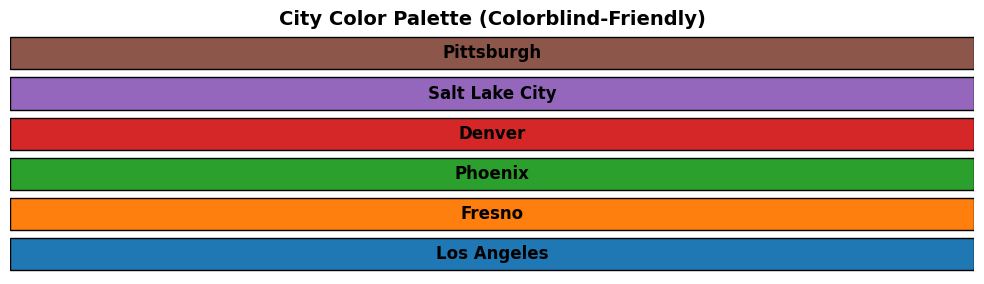

In [519]:
# Get city colors
city_colors = get_city_colors()

print("Colorblind-Friendly City Color Palette:")
print("=" * 50)
for city, color in city_colors.items():
    print(f"  {city:20s}: {color}")

# Visualize the color palette
fig, ax = plt.subplots(figsize=(10, 3))
for i, (city, color) in enumerate(city_colors.items()):
    ax.barh(i, 1, color=color, edgecolor='black', linewidth=1)
    ax.text(0.5, i, city, ha='center', va='center', fontsize=12, fontweight='bold')

ax.set_xlim(0, 1)
ax.set_ylim(-0.5, len(city_colors) - 0.5)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title('City Color Palette (Colorblind-Friendly)', fontsize=14, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.show()


### 5.3 Common Plotting Kwargs

`get_common_kwargs()` returns default keyword arguments for consistent plot styling.


In [520]:
# Get common kwargs
kwargs = get_common_kwargs()

print("Common plotting keyword arguments:")
print("=" * 50)
for key, value in kwargs.items():
    print(f"  {key}: {value}")

print("\n✓ Use with **kwargs to apply consistent styling to plots!")


Common plotting keyword arguments:
  alpha: 0.8
  linewidth: 2
  markersize: 6

✓ Use with **kwargs to apply consistent styling to plots!


### 5.4 Creating Professional Plots with All Utilities

Combining all utilities to create a professional figure with `setup_subplot_grid()` and `configure_legend_outside()`.


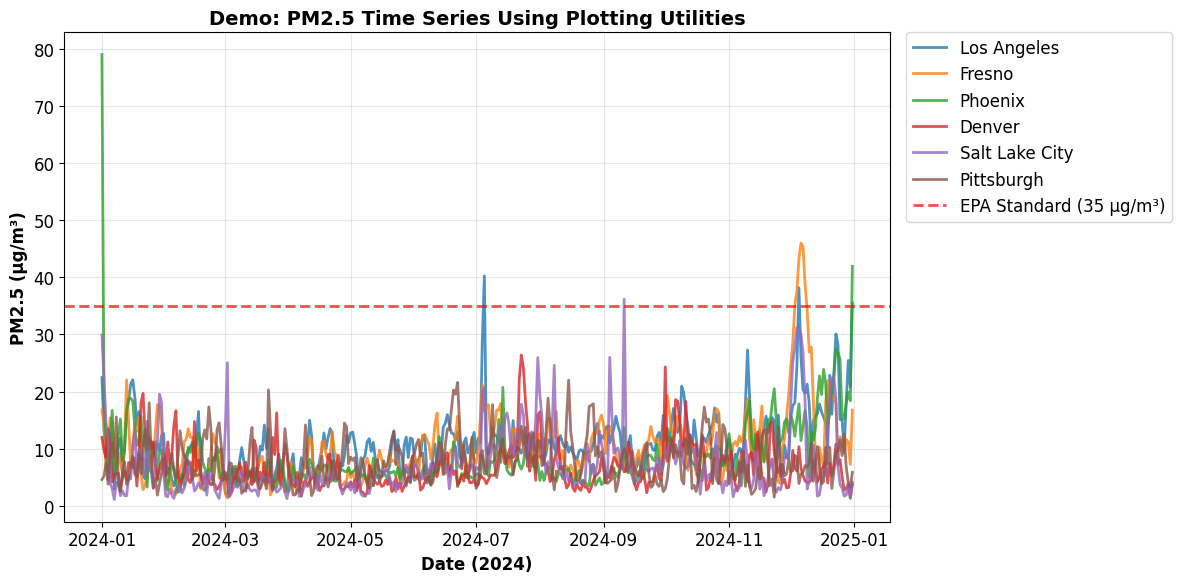

✓ Created professional figure using plotting utilities!
  - Consistent styling from get_plot_style()
  - Colorblind-friendly palette from get_city_colors()
  - Default kwargs from get_common_kwargs()
  - Subplot created with setup_subplot_grid()
  - Legend positioned with configure_legend_outside()


In [521]:
# Create a plot using all plotting utilities
fig, ax = setup_subplot_grid(figsize=(12, 6))

# Get colors and kwargs
colors = get_city_colors()
plot_kwargs = get_common_kwargs()

# Plot PM2.5 time series for each city using the utilities
for city in colors.keys():
    city_data = df[df['city'] == city].copy()
    ax.plot(city_data['date'], city_data['value'], 
            label=city, color=colors[city], **plot_kwargs)

# Add EPA standard reference line
ax.axhline(y=35, color='red', linestyle='--', linewidth=2, 
           label='EPA Standard (35 µg/m³)', alpha=0.7)

# Labels and styling
ax.set_xlabel('Date (2024)', fontweight='bold')
ax.set_ylabel('PM2.5 (µg/m³)', fontweight='bold')
ax.set_title('Demo: PM2.5 Time Series Using Plotting Utilities', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Configure legend outside plot area to avoid obscuring data
configure_legend_outside(ax)

plt.tight_layout()
plt.show()

print("✓ Created professional figure using plotting utilities!")
print("  - Consistent styling from get_plot_style()")
print("  - Colorblind-friendly palette from get_city_colors()")
print("  - Default kwargs from get_common_kwargs()")
print("  - Subplot created with setup_subplot_grid()")
print("  - Legend positioned with configure_legend_outside()")


### 5.5 Multi-Subplot Layout

Demonstrating `setup_subplot_grid()` with multiple subplots for comparing cities.


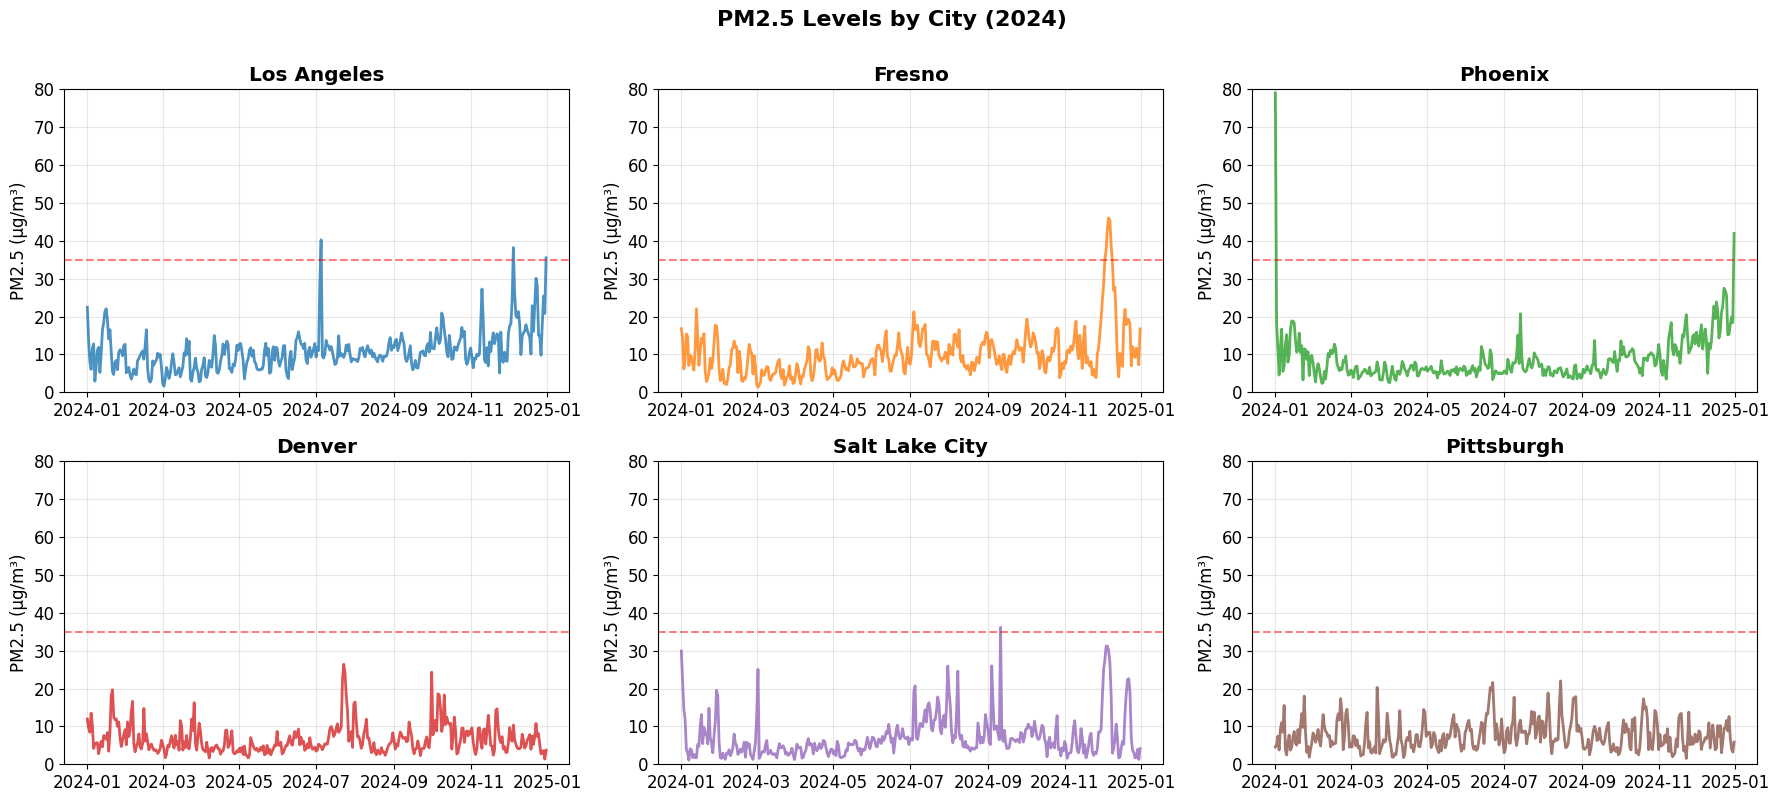

In [522]:
# Create a 2x3 grid for individual city plots
fig, axes = setup_subplot_grid(nrows=2, ncols=3)

# Get colors
colors = get_city_colors()
plot_kwargs = get_common_kwargs()

# Plot each city in its own subplot
for ax, city in zip(axes.flat, colors.keys()):
    city_data = df[df['city'] == city].copy()
    ax.plot(city_data['date'], city_data['value'], 
            color=colors[city], **plot_kwargs)
    
    # Add EPA standard line
    ax.axhline(y=35, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    
    # Styling
    ax.set_title(city, fontweight='bold')
    ax.set_ylabel('PM2.5 (µg/m³)')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 80)

# Add overall title
fig.suptitle('PM2.5 Levels by City (2024)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


## 6. Enhanced Time Series Visualization

This section demonstrates creating an enhanced time series plot that combines multiple plotting techniques:
- Raw daily values and 7-day rolling averages
- EPA threshold lines
- Shaded regions using `fill_between()`
- AQI color zones as background
- Professional styling with plotting utilities


In [523]:
# First, let's prepare the data
import matplotlib.pyplot as plt
import numpy as np

# Apply plot style
mpl.rcParams.update(get_plot_style())

# Get city colors
city_colors = get_city_colors()
cities = sorted(df['city'].unique())

print(f"Creating enhanced time series for {len(cities)} cities")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")


Creating enhanced time series for 6 cities
Date range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00


### 6.1 Helper Function: Add AQI Background Zones


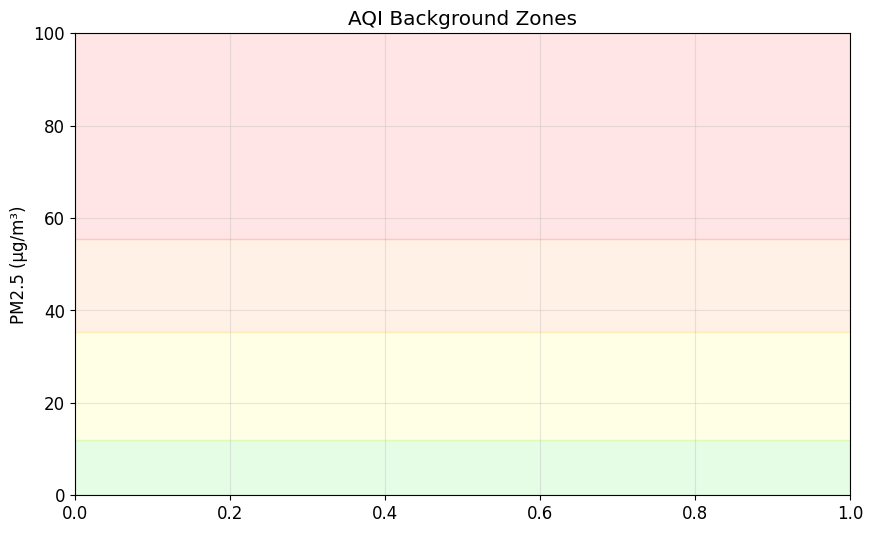

In [524]:
def add_aqi_background(ax):
    """Add AQI color zones as background shading."""
    # EPA PM2.5 AQI breakpoints with colors
    aqi_zones = [
        (0, 12.0, '#00E400', 'Good'),
        (12.0, 35.4, '#FFFF00', 'Moderate'),
        (35.4, 55.4, '#FF7E00', 'Unhealthy for Sensitive'),
        (55.4, 150.4, '#FF0000', 'Unhealthy'),
        (150.4, 250.4, '#8F3F97', 'Very Unhealthy'),
    ]
    
    for y_low, y_high, color, label in aqi_zones:
        ax.axhspan(y_low, y_high, alpha=0.1, color=color, zorder=0)

# Test the function
fig, ax = plt.subplots(figsize=(10, 6))
add_aqi_background(ax)
ax.set_ylim(0, 100)
ax.set_ylabel('PM2.5 (µg/m³)')
ax.set_title('AQI Background Zones')
ax.grid(True, alpha=0.3)
plt.show()


### 6.2 Complete Enhanced Time Series Plot

Now let's create the full enhanced visualization combining:
- Raw data and rolling averages
- EPA threshold lines
- Shaded regions with `fill_between()`
- AQI background zones


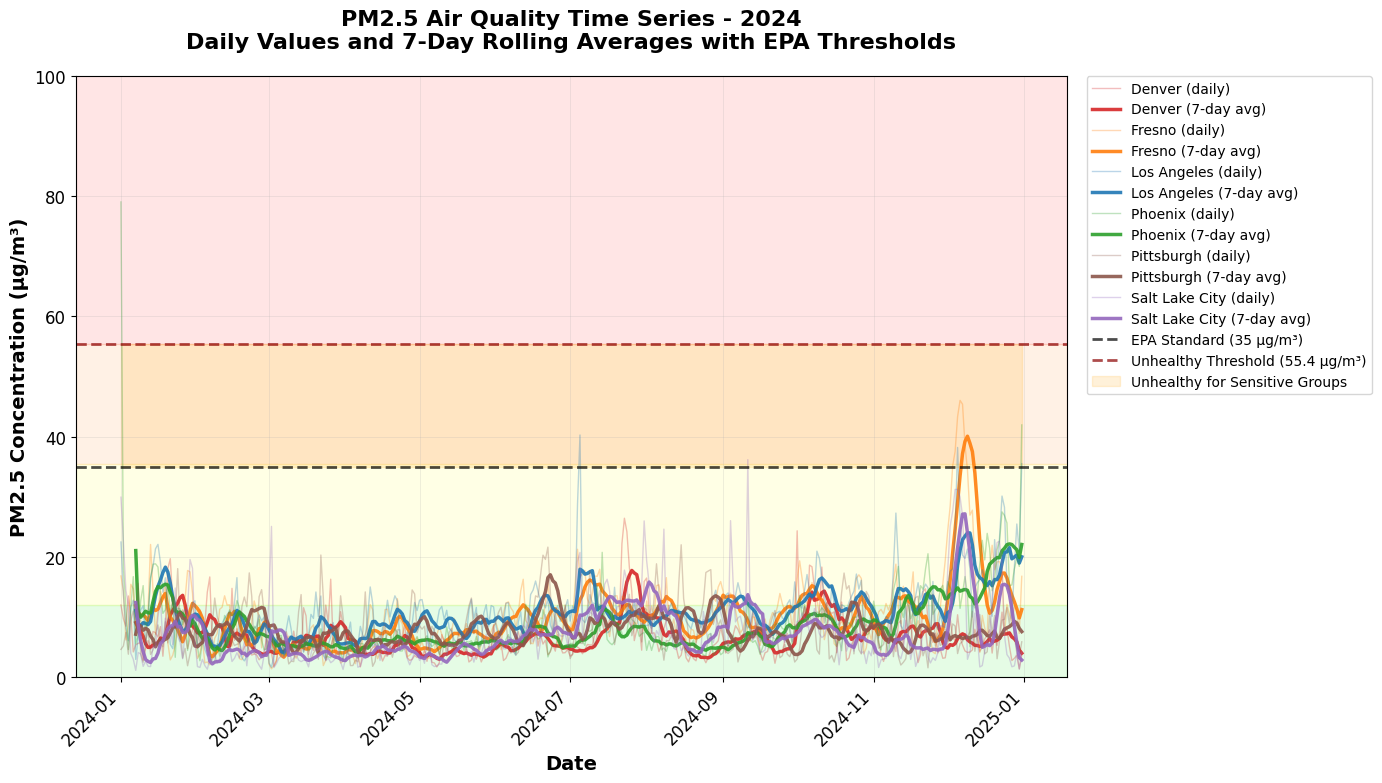


Enhanced time series plot demonstrates:
- Raw daily measurements (thin, transparent lines)
- 7-day rolling averages (thick, solid lines)
- EPA standard and unhealthy thresholds (dashed lines)
- Shaded 'Unhealthy for Sensitive Groups' zone (orange fill_between)
- AQI color zones in background for context


In [525]:
# Create figure
fig, ax = setup_subplot_grid(figsize=(14, 8))

# Add AQI background zones
add_aqi_background(ax)

# Plot each city
for city in cities:
    city_data = df[df['city'] == city].sort_values('date')
    dates = city_data['date'].values
    values = city_data['value'].values
    
    # Plot raw data with lower alpha
    ax.plot(dates, values, 
            color=city_colors[city],
            alpha=0.3,
            linewidth=1,
            label=f'{city} (daily)')
    
    # Calculate and plot 7-day rolling average
    rolling_avg = calculate_rolling_average(values, window=7)
    
    # Only plot rolling average where it's not NaN
    valid_mask = ~np.isnan(rolling_avg)
    ax.plot(dates[valid_mask], rolling_avg[valid_mask],
            color=city_colors[city],
            linewidth=2.5,
            alpha=0.9,
            label=f'{city} (7-day avg)')

# Add EPA standard line (35 µg/m³)
ax.axhline(y=35, color='black', linestyle='--', 
           linewidth=2, alpha=0.7,
           label='EPA Standard (35 µg/m³)')

# Add unhealthy threshold line (55.4 µg/m³)
ax.axhline(y=55.4, color='darkred', linestyle='--',
           linewidth=2, alpha=0.7,
           label='Unhealthy Threshold (55.4 µg/m³)')

# Add shaded region between thresholds using fill_between
ax.fill_between(dates, 35, 55.4,
                color='orange', alpha=0.15,
                label='Unhealthy for Sensitive Groups')

# Formatting
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('PM2.5 Concentration (µg/m³)', fontsize=14, fontweight='bold')
ax.set_title('PM2.5 Air Quality Time Series - 2024\n'
             'Daily Values and 7-Day Rolling Averages with EPA Thresholds',
             fontsize=16, fontweight='bold', pad=20)

# Configure legend - place outside plot area
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1),
          ncol=1, borderaxespad=0, frameon=True,
          fontsize=10)

# Grid for readability
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Rotate x-axis labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Set y-axis limits to focus on relevant range
ax.set_ylim(0, max(df['value'].max() * 1.1, 100))

plt.tight_layout()
plt.show()

print("\nEnhanced time series plot demonstrates:")
print("- Raw daily measurements (thin, transparent lines)")
print("- 7-day rolling averages (thick, solid lines)")
print("- EPA standard and unhealthy thresholds (dashed lines)")
print("- Shaded 'Unhealthy for Sensitive Groups' zone (orange fill_between)")
print("- AQI color zones in background for context")


## 7. Statistical Summary Box Plots

Box plots provide a comprehensive view of data distribution, showing quartiles, median, and outliers. This visualization allows easy comparison of PM2.5 distributions across all cities.

**Key Features:**
- Standard box plot (1.5×IQR whiskers)
- Hollow outlier markers following matplotlib defaults
- Consistent y-axis scale for fair comparison
- EPA standard reference line


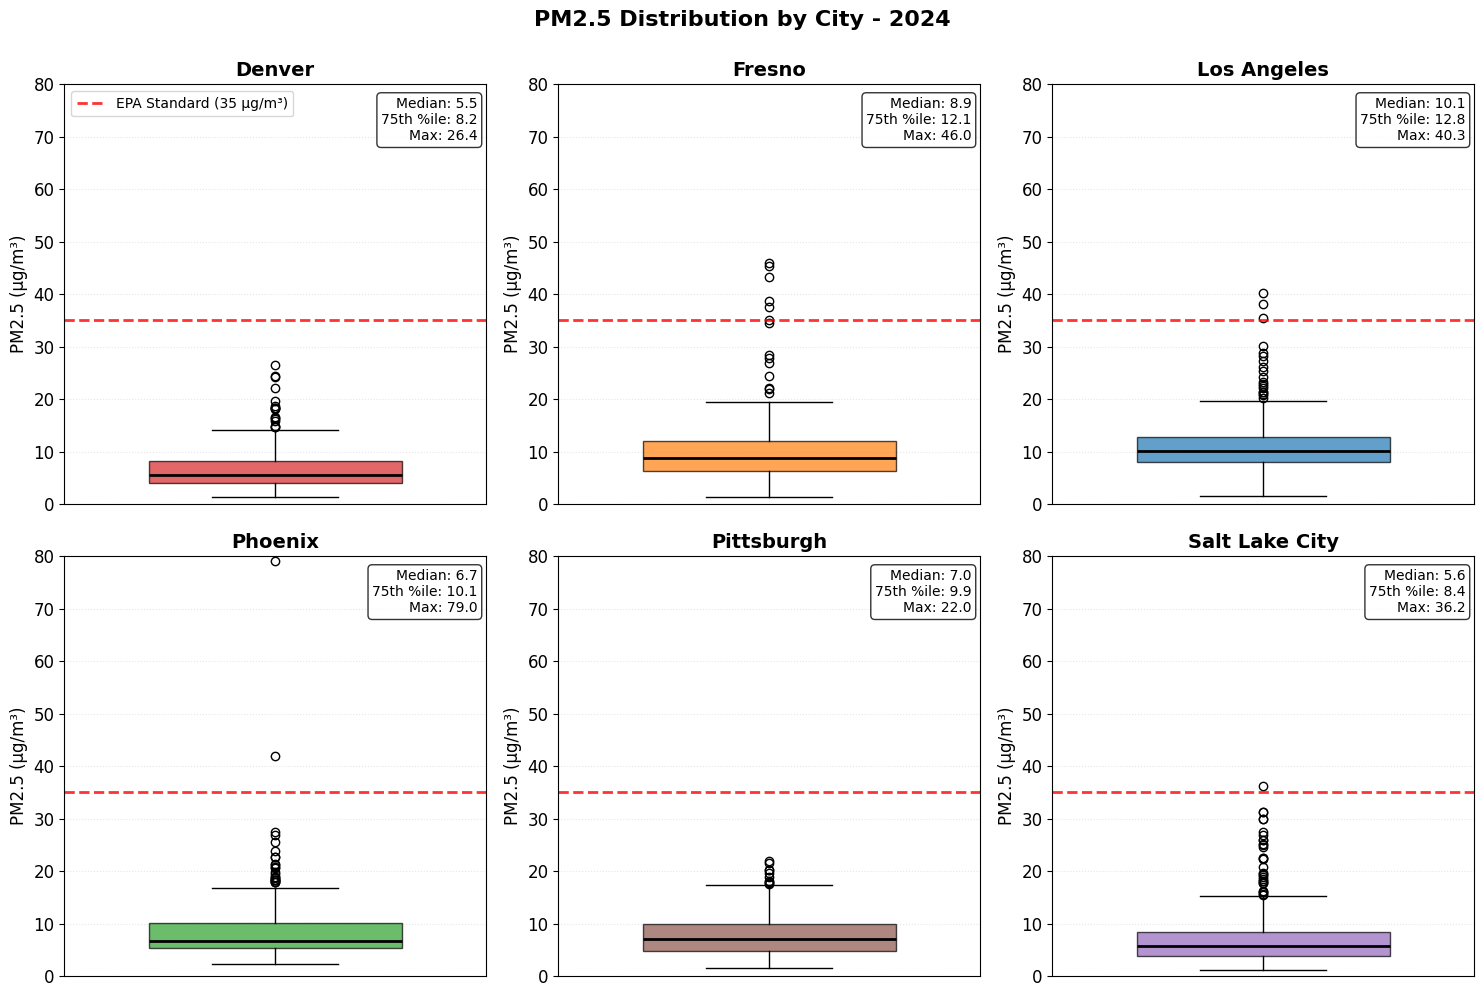

In [526]:
# Get cities and colors
cities = get_cities_list(df)
colors = get_city_colors()

# EPA standard threshold
epa_standard = 35.0

# Find global max for consistent y-axis scaling
global_max = df['value'].max()
y_max = np.ceil(global_max / 10) * 10

# Create 2x3 subplot grid
fig, axes = setup_subplot_grid(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Create box plot for each city
for idx, city in enumerate(cities):
    ax = axes[idx]
    
    # Filter data for this city
    city_df = df[df['city'] == city]
    values = city_df['value'].values
    
    # Create box plot (following matplotlib defaults)
    ax.boxplot(
        [values],
        widths=0.6,
        patch_artist=True,
        showfliers=True,
        flierprops=dict(
            marker='o',
            markersize=6,
            markerfacecolor='none',
            markeredgecolor='black',
            markeredgewidth=1.0
        ),
        medianprops=dict(color='black', linewidth=2),
        boxprops=dict(
            facecolor=colors[city],
            alpha=0.7,
            edgecolor='black',
            linewidth=1.0
        ),
        whiskerprops=dict(linewidth=1.0, color='black'),
        capprops=dict(linewidth=1.0, color='black')
    )
    
    # Add EPA standard line
    ax.axhline(
        epa_standard,
        color='red',
        linestyle='--',
        linewidth=2,
        label='EPA Standard (35 μg/m³)',
        alpha=0.8
    )
    
    # Calculate summary statistics for annotation
    median_val = np.median(values)
    q75 = np.percentile(values, 75)
    max_val = np.max(values)
    
    # Add text annotation with key statistics
    stats_text = (
        f'Median: {median_val:.1f}\n'
        f'75th %ile: {q75:.1f}\n'
        f'Max: {max_val:.1f}'
    )
    ax.text(
        0.98, 0.97,
        stats_text,
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        fontsize=10,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )
    
    # Styling
    ax.set_title(city, fontsize=14, fontweight='bold')
    ax.set_ylabel('PM2.5 (μg/m³)', fontsize=12)
    ax.set_xticks([])
    ax.grid(axis='y', alpha=0.3, linestyle=':')
    # Set consistent y-axis limits across all subplots
    ax.set_ylim(0, y_max)
    
    # Add legend only to first subplot
    if idx == 0:
        ax.legend(loc='upper left', fontsize=10)

# Overall title
fig.suptitle(
    'PM2.5 Distribution by City - 2024',
    fontsize=16,
    fontweight='bold',
    y=0.995
)

plt.tight_layout()
plt.show()



### Outlier Analysis

Let's verify the outlier counts for each city:


In [527]:
# Calculate outliers for each city using 1.5×IQR rule
print("Outlier Analysis (1.5×IQR rule):")
print("=" * 70)

for city in cities:
    city_data = df[df['city'] == city]['value'].values
    
    # Calculate quartiles
    q1 = np.percentile(city_data, 25)
    q3 = np.percentile(city_data, 75)
    iqr = q3 - q1
    
    # Calculate outlier bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Find outliers
    outliers = city_data[(city_data < lower_bound) | (city_data > upper_bound)]
    
    print(f'\n{city}:')
    print(f'  Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}')
    print(f'  Outlier bounds: [{lower_bound:.2f}, {upper_bound:.2f}]')
    print(f'  Number of outliers: {len(outliers)} out of {len(city_data)} days ({100*len(outliers)/len(city_data):.1f}%)')
    if len(outliers) > 0:
        print(f'  Outlier range: {outliers.min():.2f} - {outliers.max():.2f} μg/m³')


Outlier Analysis (1.5×IQR rule):

Denver:
  Q1: 4.09, Q3: 8.18, IQR: 4.09
  Outlier bounds: [-2.04, 14.32]
  Number of outliers: 17 out of 366 days (4.6%)
  Outlier range: 14.65 - 26.41 μg/m³

Fresno:
  Q1: 6.25, Q3: 12.08, IQR: 5.83
  Outlier bounds: [-2.50, 20.82]
  Number of outliers: 14 out of 366 days (3.8%)
  Outlier range: 21.25 - 46.02 μg/m³

Los Angeles:
  Q1: 7.93, Q3: 12.77, IQR: 4.84
  Outlier bounds: [0.66, 20.04]
  Number of outliers: 19 out of 366 days (5.2%)
  Outlier range: 20.28 - 40.26 μg/m³

Phoenix:
  Q1: 5.30, Q3: 10.14, IQR: 4.84
  Outlier bounds: [-1.96, 17.40]
  Number of outliers: 24 out of 366 days (6.6%)
  Outlier range: 17.84 - 79.04 μg/m³

Pittsburgh:
  Q1: 4.77, Q3: 9.90, IQR: 5.13
  Outlier bounds: [-2.93, 17.60]
  Number of outliers: 10 out of 366 days (2.7%)
  Outlier range: 17.63 - 21.99 μg/m³

Salt Lake City:
  Q1: 3.74, Q3: 8.41, IQR: 4.67
  Outlier bounds: [-3.26, 15.41]
  Number of outliers: 30 out of 366 days (8.2%)
  Outlier range: 15.41 - 36.16

## 8. Extreme Events Comparison

This section demonstrates the extreme events analysis using grouped bar charts to compare exceedance counts across cities using different threshold definitions.


In [528]:
# Calculate exceedance counts for each city using two different thresholds
import numpy as np

# Define thresholds
epa_standard = 35.0  # EPA 24-hour standard
percentile_95 = np.percentile(df['value'].dropna(), 95)

print(f"EPA Standard: {epa_standard:.1f} μg/m³")
print(f"95th Percentile: {percentile_95:.1f} μg/m³")
print()

# Calculate exceedance counts for each city
epa_counts = []
percentile_counts = []

for city in cities:
    city_df = filter_by_city(df, city)
    values = city_df['value'].values
    
    # Count EPA standard exceedances
    epa_count = calculate_exceedance_count(values, epa_standard)
    epa_counts.append(epa_count)
    
    # Count 95th percentile exceedances
    p95_count = calculate_exceedance_count(values, percentile_95)
    percentile_counts.append(p95_count)
    
    print(f"{city:20s} - EPA: {epa_count:3d} days, 95th %ile: {p95_count:3d} days")


EPA Standard: 35.0 μg/m³
95th Percentile: 17.9 μg/m³

Denver               - EPA:   0 days, 95th %ile:  10 days
Fresno               - EPA:   6 days, 95th %ile:  21 days
Los Angeles          - EPA:   3 days, 95th %ile:  28 days
Phoenix              - EPA:   2 days, 95th %ile:  21 days
Pittsburgh           - EPA:   0 days, 95th %ile:   7 days
Salt Lake City       - EPA:   1 days, 95th %ile:  23 days


### 8.1 Grouped Bar Chart Visualization

Create a grouped bar chart comparing exceedance counts across cities. This demonstrates the `bar()` matplotlib command with grouped positioning.


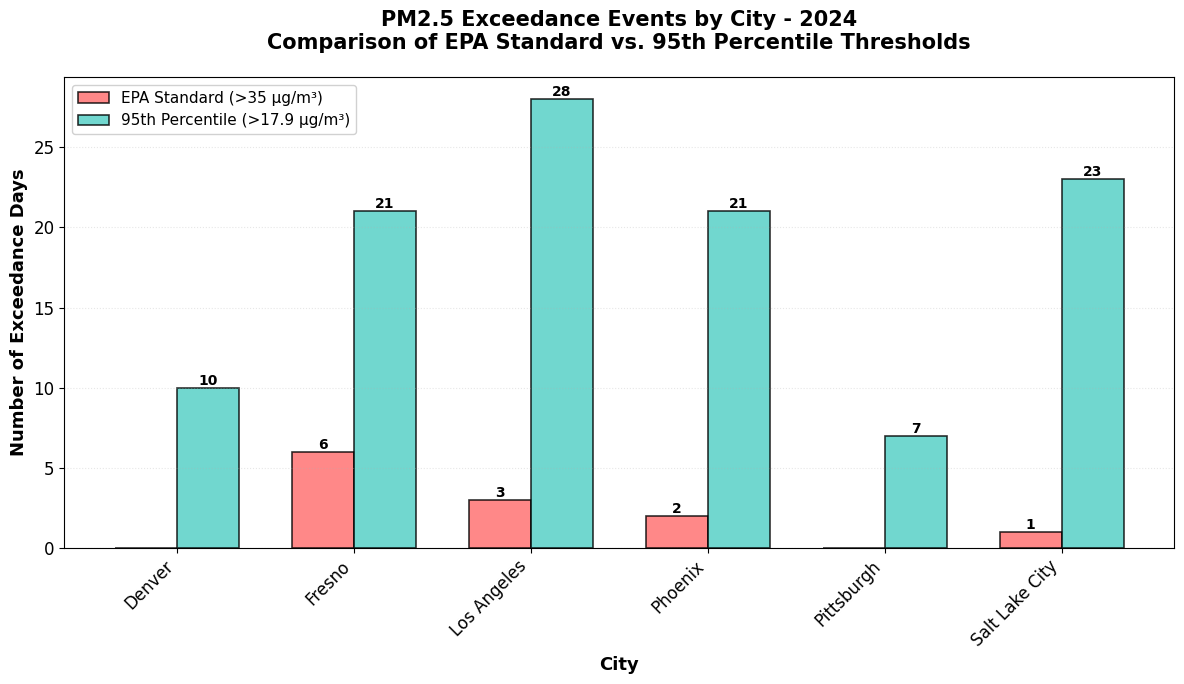

In [529]:
# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 7))

# Set up grouped bar positions
x = np.arange(len(cities))
width = 0.35  # Width of bars

# Create grouped bars
bars1 = ax.bar(
    x - width/2,
    epa_counts,
    width,
    label=f'EPA Standard (>{epa_standard:.0f} μg/m³)',
    color='#FF6B6B',
    alpha=0.8,
    edgecolor='black',
    linewidth=1.2
)

bars2 = ax.bar(
    x + width/2,
    percentile_counts,
    width,
    label=f'95th Percentile (>{percentile_95:.1f} μg/m³)',
    color='#4ECDC4',
    alpha=0.8,
    edgecolor='black',
    linewidth=1.2
)

# Add value labels on bars
def add_value_labels(bars):
    """Add text labels on top of bars."""
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only label non-zero bars
            ax.text(
                bar.get_x() + bar.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=10,
                fontweight='bold'
            )

add_value_labels(bars1)
add_value_labels(bars2)

# Styling
ax.set_xlabel('City', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Exceedance Days', fontsize=13, fontweight='bold')
ax.set_title(
    'PM2.5 Exceedance Events by City - 2024\n'
    'Comparison of EPA Standard vs. 95th Percentile Thresholds',
    fontsize=15,
    fontweight='bold',
    pad=20
)
ax.set_xticks(x)
ax.set_xticklabels(cities, rotation=45, ha='right')
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle=':')
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()


### 8.2 Detailed Extreme Events Analysis

For cities with exceedances, we can examine the specific dates and values using the `identify_extremes_threshold()` function.


In [530]:
# Examine extreme events for all cities
from air_quality.extremes import identify_extremes_threshold

print("EPA Standard Exceedances by City")
print("=" * 70)

for city in cities:
    city_df = filter_by_city(df, city)
    city_df_with_date = pd.DataFrame({
        'Date': city_df['date'],
        'PM2.5': city_df['value']
    })
    
    extremes = identify_extremes_threshold(city_df_with_date, epa_standard)
    
    print(f"\n{city}:")
    if len(extremes) == 0:
        print("  No exceedances - excellent air quality!")
    else:
        print(f"  {len(extremes)} exceedance day(s)")
        print(extremes.to_string(index=False))
    print("-" * 70)


EPA Standard Exceedances by City

Denver:
  No exceedances - excellent air quality!
----------------------------------------------------------------------

Fresno:
  6 exceedance day(s)
      Date     PM2.5
2024-12-06 46.021436
2024-12-07 45.382639
2024-12-05 43.312054
2024-12-08 38.602564
2024-12-04 37.537847
2024-12-03 35.087500
----------------------------------------------------------------------

Los Angeles:
  3 exceedance day(s)
      Date     PM2.5
2024-07-05 40.259259
2024-12-05 38.184907
2024-12-31 35.492361
----------------------------------------------------------------------

Phoenix:
  2 exceedance day(s)
      Date     PM2.5
2024-01-01 79.038750
2024-12-31 41.934954
----------------------------------------------------------------------

Pittsburgh:
  No exceedances - excellent air quality!
----------------------------------------------------------------------

Salt Lake City:
  1 exceedance day(s)
      Date     PM2.5
2024-09-11 36.157696
--------------------------------